# Calibrating a camera with OpenCV


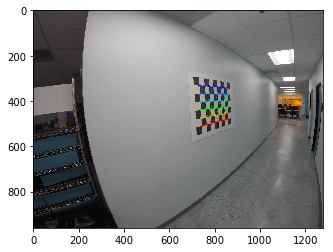

In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        clear_output()
        plt.imshow(img)
        plt.show()
        time.sleep(1)

If the above cell ran sucessfully, you should now have _objpoints_ and _imgpoints_ needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

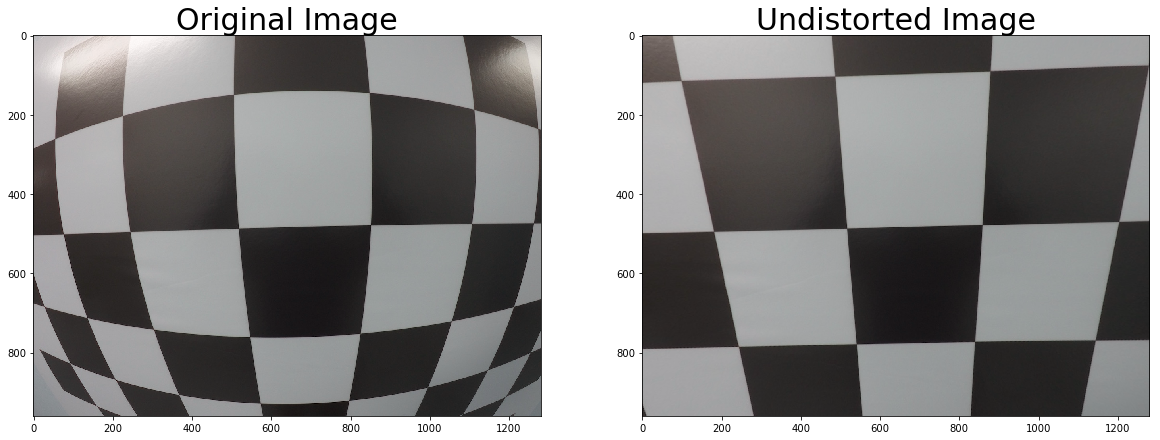

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Undistort and Transform Perspective

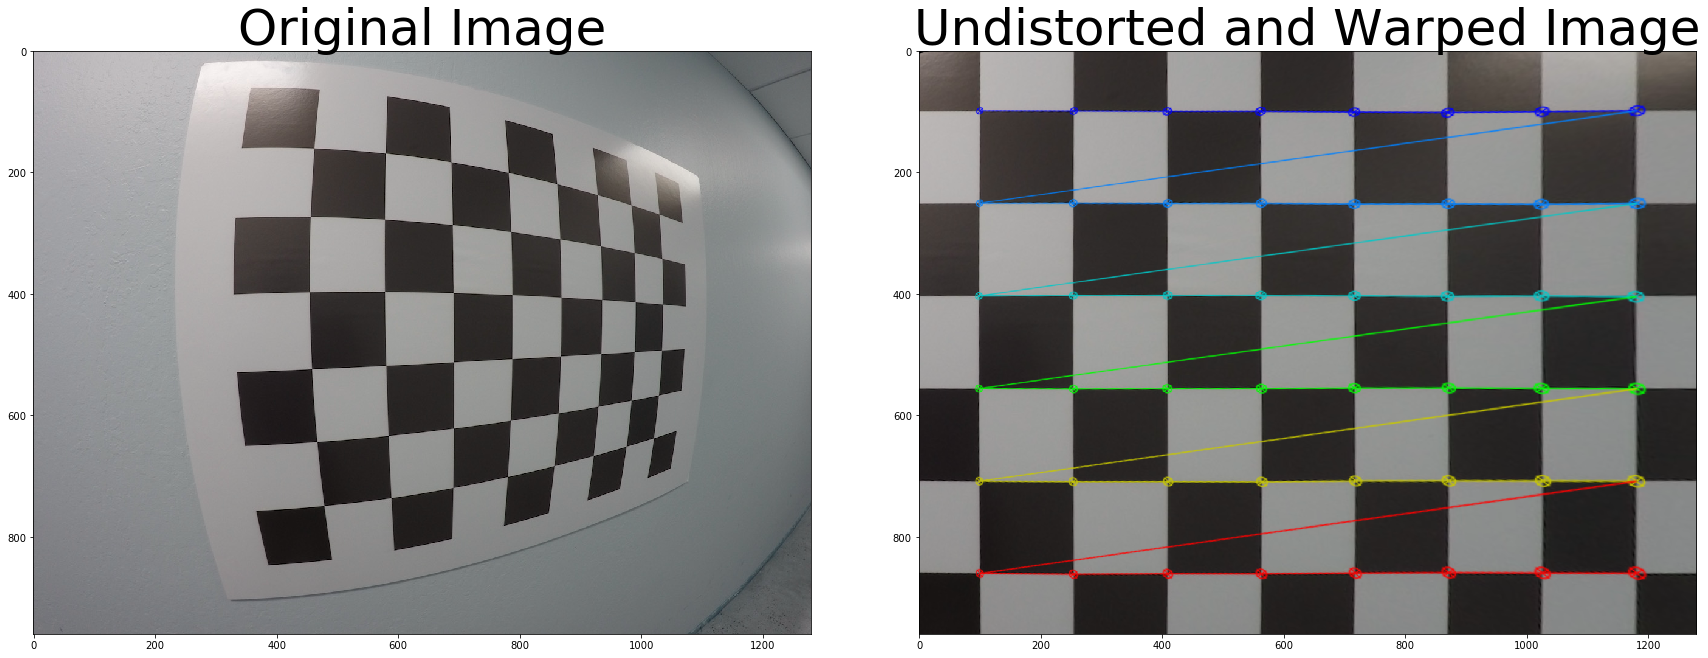

In [27]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('calibration_wide/GOPR0032.jpg')
#img = cv2.imread('test_image2.png')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # 1) Undistort using mtx and dist
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
    if ret == True:
        offset = 100 # offset for dst points
        img_size = (undistorted.shape[1],undistorted.shape[0])
        # a) draw corners
        cv2.drawChessboardCorners(undistorted, (8,6), corners, ret)
        # b) define 4 source points. Using detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # d) get the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
